In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
file_path = '/Users/michaelezeanioma/sqlalchemy-challenge/Resources/hawaii_measurements.csv'
data = pd.read_csv(file_path)

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.sql import text
from sqlalchemy import create_engine, func, inspect
from datetime import timedelta, datetime

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

/var/folders/sy/0blmjqvn66q9pd453v1y2zdh0000gn/T/ipykernel_10945/1652790876.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
print("Tables/classes found:", base.classes.keys())

Tables/classes found: ['station', 'measurement']


In [8]:
# Save references to each table
measurement = base.classes.measurement #name of tables
stations = base.classes.station

In [9]:
# Create/start our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date_str = session.query(func.max(measurement.date)).scalar()
recent_date_str
#print(type(recent_date))

'2017-08-23'

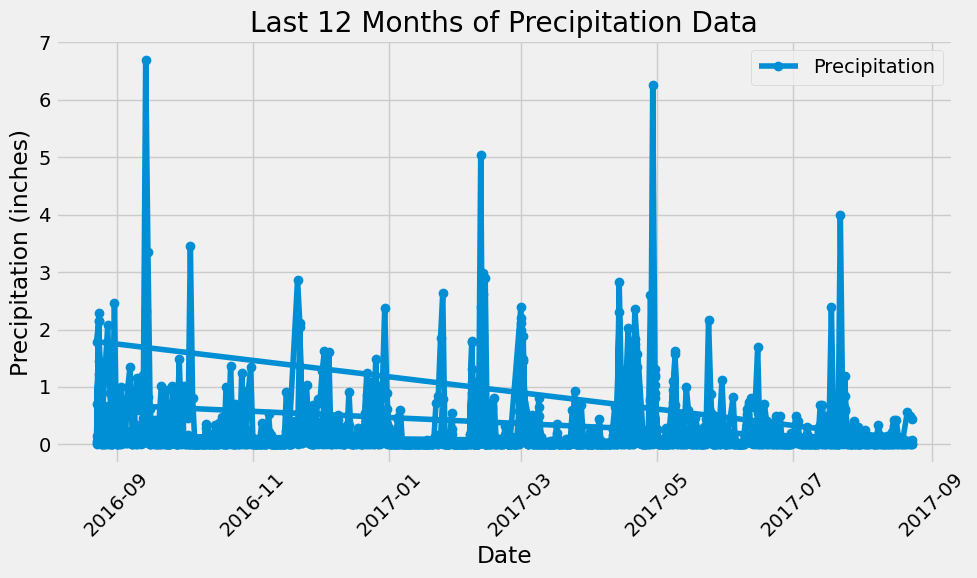

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
#recent_date = session.query(func.max(precipitation.date)).scalar()
#class Precipitation:
    #pass

data['date'] = pd.to_datetime(data['date'])

# Convert the recent date to a datetime object
#recent_date = datetime.strptime(recent_date_str, "%Y-%m-%d")
recent_date = data['date'].max()
# Calculate the date one year from the last date in data set.
one_year_ago = recent_date - timedelta(days=365)

# Filter data for the last 12 months and remove rows with NaN in 'prcp'
last_12_months_data = data[(data['date'] >= one_year_ago) & (data['prcp'].notna())]

# Perform a query to retrieve the data and precipitation scores
results = (
    session.query(measurement.date, measurement.prcp) #.filter(measurement.date >= one_year_ago)
    .order_by(measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'prcp'])

# Sort the dataframe by date
df['date'] = pd.to_datetime(df['date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(last_12_months_data ['date'], last_12_months_data ['prcp'], marker='o', linestyle='-', label='Precipitation')
plt.title('Last 12 Months of Precipitation Data')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = last_12_months_data['prcp'].describe().to_frame()
summary_stats.columns = ['Precipitation']
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
stations_file_path = '/Users/michaelezeanioma/sqlalchemy-challenge/Resources/hawaii_stations.csv'
stations_data = pd.read_csv(stations_file_path)

total_stations = stations_data['station'].nunique()

print(total_stations)

9


In [21]:
'''# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = station.groupby('station').size().reset_index(name='counts')

stations_activityy = station_activity.sort_values(by='counts', ascendinng=False)

#station_activity_tuples = list(station_activity.itertuples(index=False, name=None))

print(station_activityy)
'''

# Query to find the most active stations and their counts
query = """
SELECT station, COUNT(*) as count
FROM measurement
GROUP BY station
ORDER BY count DESC;
"""

# Execute the query and fetch results using SQLAlchemy
with engine.connect() as connection:
    results = connection.execute(text(query)).fetchall()

#active_stations_df = pd.DataFrame(results, columns=['Station', 'Count'])

# Display the DataFrame
print(active_stations_df)


       Station  Count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
5  USC00514830   2202
6  USC00511918   1979
7  USC00517948   1372
8  USC00518838    511


In [46]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find the most active station ID
most_active_station = data['station'].value_counts().idxmax()
#most_active_station

# Filter data for the most active station and calculate temperature statistics
active_station_data = data[data['station'] == most_active_station]
active_station_data

lowest_temp = active_station_data['tobs'].min()
highest_temp = active_station_data['tobs'].max()
average_temp = active_station_data['tobs'].mean()

# Format the output
output = [(lowest_temp, highest_temp, average_temp)]
print(output)

[(54, 85, 71.66378066378067)]


Text(0.5, 0, 'Temperature')


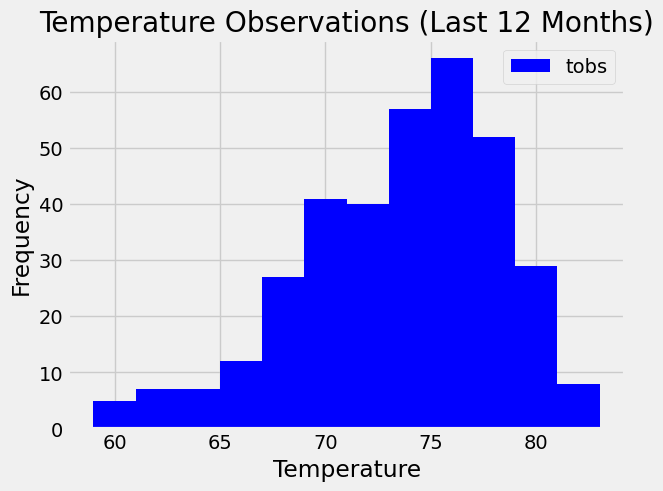

In [58]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

most_active_station = data['station'].value_counts().idxmax()
#most_active_station

# Determine the last date in the dataset and calculate the date 12 months earlier
last_date = data['date'].max()
one_year_ago = last_date - pd.DateOffset(years=1)

# Filter data for the most active station and the last 12 months
last_12_months_data = data[
    (data['station'] == most_active_station) & (data['date'] > one_year_ago)
]

# Plot the histogram of temperature observations
plt.hist(last_12_months_data['tobs'], bins=12, label='tobs', color='blue')
xlabel = plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.title('Temperature Observations (Last 12 Months)')


# Output the xlabel text value
print(xlabel)

# Show the plot
plt.show()



# Close Session

In [59]:
# Close Session
session.close()